In [205]:
import math
import matplotlib.pyplot as plt
import plotly.express as px
import keras
import pandas as pd
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping



In [206]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [207]:
def apply_LSTM(df1, split_percentage, days_to_predict=5): 
    plt.plot(df1)
    # scaling 
    scaler=MinMaxScaler(feature_range=(0,1))
    df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

    ##splitting dataset into train and test split
    training_size=int(len(df1)*split_percentage)
    test_size=len(df1)-training_size
    train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
    print("Sizes train and test: ", training_size,test_size)

    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, ytest = create_dataset(test_data, time_step)
    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    history=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    ### Lets Do the prediction and check performance metrics
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)
    ##Transform back to original form
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    ### Test Data RMSE
    test_mse = math.sqrt(mean_squared_error(ytest,test_predict))
    value_mae = mean_absolute_error(ytest, test_predict)
    value_mse = mean_squared_error(ytest, test_predict)
    value_r2 = r2_score(ytest, test_predict)
    value_rmse = math.sqrt(value_mse)
    print("Test RMSE value: "+str(test_mse))
    print("Test mae value: "+str(value_mae))
    print("Test mse value: "+str(value_mse))
    print("Test r2 value: "+str(value_r2))
    print("Test rmse2 value: "+str(value_rmse))



    ### Plotting 
    # shift train predictions for plotting
    look_back=100
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(df1))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.title("Train and Test Predict Plot")
    plt.show()

    x_input=test_data[(len(test_data)-100):].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    # demonstrate prediction for next 10 days
    lst_output=[]
    n_steps=100
    i=0
    
    while(i<days_to_predict):
        
        if(len(temp_input)>100):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
        
    day_new=np.arange(1,101)
    day_pred=np.arange(101,101+days_to_predict)

    plt.plot(day_new,scaler.inverse_transform(df1[(len(df1)-100):]))
    plt.plot(day_pred,scaler.inverse_transform(lst_output))
    plt.title("df1 + lst output")
    plt.show()
    print(scaler.inverse_transform(lst_output))

    df3=df1.tolist()
    df3.extend(lst_output)
    df3=scaler.inverse_transform(df3).tolist()
    
    fig = px.line(df3)
    fig.show()   

# ETH

In [208]:
result1 = pd.read_csv(r'../data/updated_data_ind/eth_ind.csv')

In [209]:
start_date = '2021-01-01'

In [210]:
result1 = result1[result1['Date']> start_date].copy()

In [211]:
df1=result1.reset_index()['close']


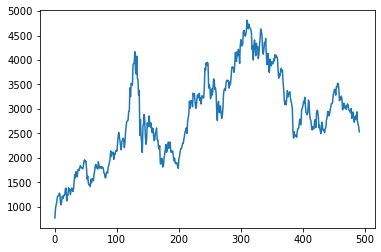

In [212]:
plt.plot(df1)

Sizes train and test:  369 123
Epoch 1/100
5/5 [==============================] - 7s 427ms/step - loss: 0.2600 - val_loss: 0.0114
Epoch 2/100
5/5 [==============================] - 1s 188ms/step - loss: 0.0471 - val_loss: 0.0105
Epoch 3/100
5/5 [==============================] - 1s 193ms/step - loss: 0.0221 - val_loss: 0.0024
Epoch 4/100
5/5 [==============================] - 1s 197ms/step - loss: 0.0240 - val_loss: 0.0115
Epoch 5/100
5/5 [==============================] - 1s 226ms/step - loss: 0.0166 - val_loss: 0.0244
Epoch 6/100
5/5 [==============================] - 1s 231ms/step - loss: 0.0147 - val_loss: 0.0040
Epoch 7/100
5/5 [==============================] - 1s 302ms/step - loss: 0.0156 - val_loss: 0.0019
Epoch 8/100
5/5 [==============================] - 1s 224ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 9/100
5/5 [==============================] - 1s 198ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 10/100
5/5 [==============================] - 1s 191ms/step - loss: 0.01

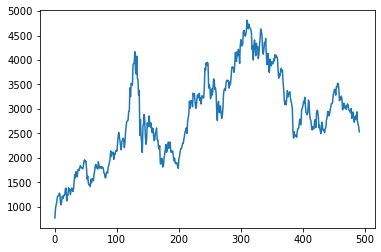

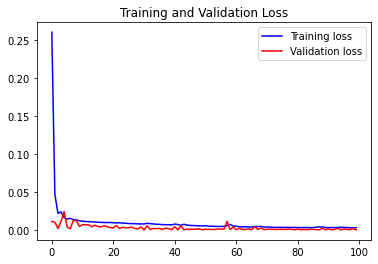

Test RMSE value: 2899.6439679507016
Test mae value: 2897.761128295007
Test mse value: 8407935.140872888
Test r2 value: -8341815262.913774
Test rmse2 value: 2899.6439679507016


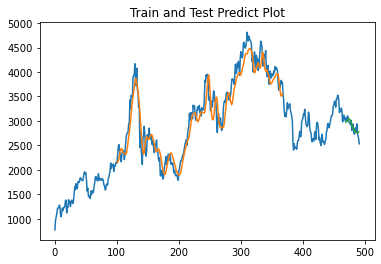

[0.47466093]
101
1 day input [0.45298027 0.47398613 0.49970428 0.47264254 0.47172827 0.5471265
 0.5548196  0.56542699 0.58647801 0.58155868 0.61049908 0.57038199
 0.53320634 0.53072446 0.52232843 0.53471604 0.59574266 0.5828519
 0.52183767 0.49812172 0.49266635 0.45921719 0.44563661 0.46185514
 0.44973401 0.45164297 0.49287302 0.49697852 0.45752144 0.53117978
 0.54437687 0.5388372  0.51019375 0.4563708  0.46817871 0.44098558
 0.4268022  0.44636265 0.48426578 0.45411512 0.44210646 0.44586893
 0.4320463  0.44981733 0.45711225 0.49473554 0.50533573 0.53765445
 0.53788084 0.51663088 0.52592298 0.54453686 0.55888616 0.57795585
 0.57761143 0.58665343 0.62340804 0.6345675  0.65075386 0.64658553
 0.62094744 0.66253437 0.66142159 0.68068429 0.68028992 0.65318223
 0.59371537 0.60896787 0.59876349 0.61606167 0.60366571 0.54649873
 0.5587151  0.5805025  0.55612267 0.5613256  0.5666243  0.54955778
 0.56545934 0.57697615 0.5704473  0.5480909  0.5424823  0.53586401
 0.53205444 0.55351816 0.50371194 0

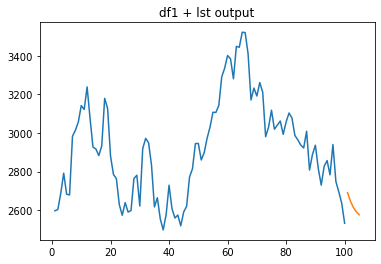

[[2691.0033763 ]
 [2646.19908198]
 [2613.67731309]
 [2591.46083271]
 [2576.36214049]]


In [213]:
apply_LSTM(df1, split_percentage=0.75)

# ADA 

In [214]:
result1 = pd.read_csv(r'../data/updated_data_ind/ada_ind.csv')

In [215]:
start_date = '2021-02-13'

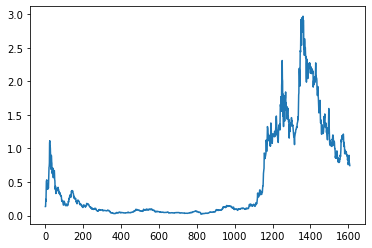

In [216]:
plt.plot(result1['close'])

In [217]:
result1 = result1[result1['Date']> start_date].copy()

In [218]:
df1=result1.reset_index()['close']

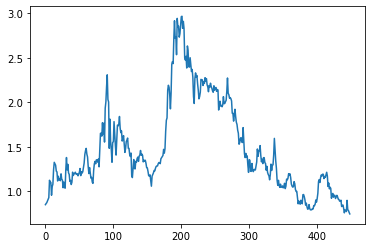

In [219]:
plt.plot(df1)

Sizes train and test:  336 113
Epoch 1/100
4/4 [==============================] - 6s 649ms/step - loss: 0.2379 - val_loss: 0.0074
Epoch 2/100
4/4 [==============================] - 1s 202ms/step - loss: 0.0540 - val_loss: 0.0685
Epoch 3/100
4/4 [==============================] - 1s 200ms/step - loss: 0.0413 - val_loss: 0.0274
Epoch 4/100
4/4 [==============================] - 1s 215ms/step - loss: 0.0286 - val_loss: 0.0173
Epoch 5/100
4/4 [==============================] - 1s 196ms/step - loss: 0.0299 - val_loss: 0.0258
Epoch 6/100
4/4 [==============================] - 1s 192ms/step - loss: 0.0198 - val_loss: 0.0413
Epoch 7/100
4/4 [==============================] - 1s 193ms/step - loss: 0.0225 - val_loss: 0.0354
Epoch 8/100
4/4 [==============================] - 1s 192ms/step - loss: 0.0178 - val_loss: 0.0218
Epoch 9/100
4/4 [==============================] - 1s 192ms/step - loss: 0.0176 - val_loss: 0.0184
Epoch 10/100
4/4 [==============================] - 1s 193ms/step - loss: 0.01

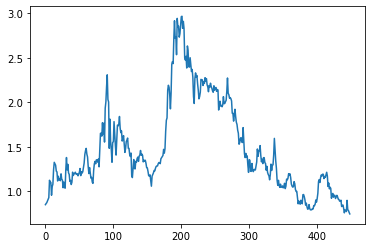

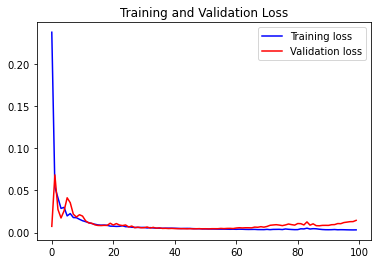

Test RMSE value: 1.041629961125762
Test mae value: 1.0410450424586337
Test mse value: 1.0849929759148564
Test r2 value: -3477.716151595925
Test rmse2 value: 1.041629961125762


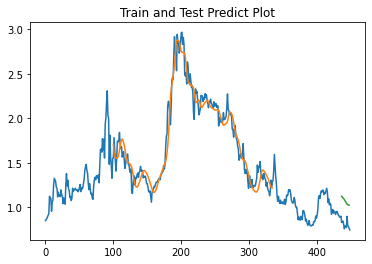

[0.12393811]
101
1 day input [0.1318016  0.13847013 0.15480244 0.12794933 0.14033224 0.17593673
 0.17221391 0.17994906 0.2036734  0.19531548 0.20255061 0.18351536
 0.15108054 0.1411214  0.13555454 0.13755462 0.16332901 0.1531643
 0.12389738 0.11365312 0.11391844 0.08477966 0.05120497 0.06504611
 0.05612116 0.04904164 0.0690976  0.06455193 0.05124949 0.09688737
 0.09801962 0.08736974 0.07118044 0.04430396 0.05454867 0.0356987
 0.0238397  0.02558033 0.04718361 0.02785836 0.02057782 0.02082467
 0.02096903 0.0267796  0.02502095 0.04227372 0.04155875 0.04904523
 0.07047898 0.05968386 0.07753108 0.1043572  0.16328221 0.17341272
 0.15896814 0.18266819 0.19685692 0.19147715 0.20088775 0.20056082
 0.17873675 0.18933716 0.18510226 0.1985625  0.21070527 0.1917546
 0.13868058 0.15627286 0.12678917 0.13519298 0.12883921 0.07918043
 0.09478158 0.10357297 0.08455935 0.09458911 0.09365516 0.07783863
 0.086501   0.09396679 0.08677572 0.07469458 0.0732017  0.06481499
 0.06384684 0.06939797 0.03744926 0.

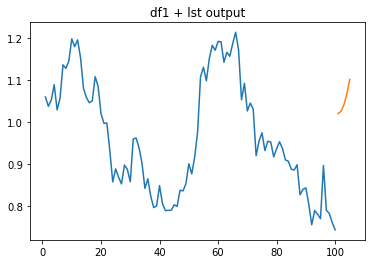

[[1.01998554]
 [1.0254594 ]
 [1.04101176]
 [1.06665603]
 [1.10107345]]


In [220]:
apply_LSTM(df1, split_percentage=0.75)

# Atom

In [221]:
result1 = pd.read_csv(r'../data/updated_data_ind/atom_ind.csv')

In [222]:
start_date = '2021-01-11'

In [223]:
result1 = result1[result1['Date']> start_date].copy()

In [224]:
df1=result1.reset_index()['close']

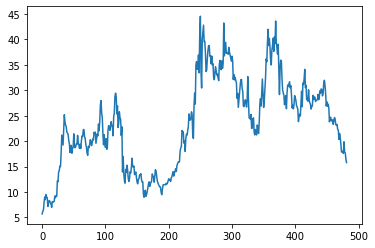

In [225]:
plt.plot(df1)

Sizes train and test:  361 121
Epoch 1/100
5/5 [==============================] - 6s 487ms/step - loss: 0.1829 - val_loss: 0.0105
Epoch 2/100
5/5 [==============================] - 1s 170ms/step - loss: 0.0399 - val_loss: 0.0605
Epoch 3/100
5/5 [==============================] - 1s 176ms/step - loss: 0.0224 - val_loss: 0.0023
Epoch 4/100
5/5 [==============================] - 1s 167ms/step - loss: 0.0324 - val_loss: 0.0050
Epoch 5/100
5/5 [==============================] - 1s 165ms/step - loss: 0.0203 - val_loss: 0.0333
Epoch 6/100
5/5 [==============================] - 1s 168ms/step - loss: 0.0213 - val_loss: 0.0228
Epoch 7/100
5/5 [==============================] - 1s 183ms/step - loss: 0.0170 - val_loss: 0.0046
Epoch 8/100
5/5 [==============================] - 1s 169ms/step - loss: 0.0177 - val_loss: 0.0112
Epoch 9/100
5/5 [==============================] - 1s 169ms/step - loss: 0.0143 - val_loss: 0.0217
Epoch 10/100
5/5 [==============================] - 1s 187ms/step - loss: 0.01

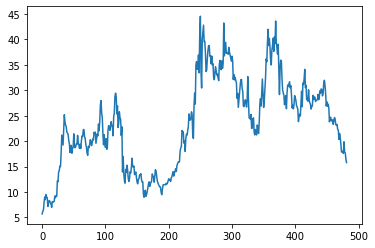

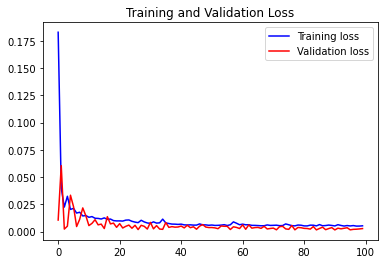

Test RMSE value: 21.82892036700725
Test mae value: 21.686814928771618
Test mse value: 476.50176438914394
Test r2 value: -106848.25452071842
Test rmse2 value: 21.82892036700725


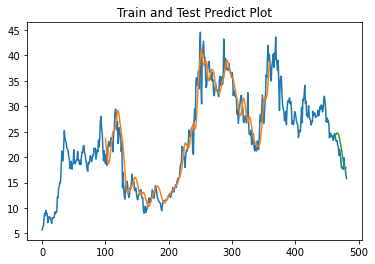

[0.30902463]
101
1 day input [0.55246858 0.57765282 0.59821324 0.53229196 0.6122529  0.65219504
 0.64617057 0.65781003 0.66870703 0.6379706  0.64883358 0.60343682
 0.53676867 0.54949642 0.53153345 0.55300165 0.59826416 0.58785235
 0.57397287 0.54732774 0.54035724 0.52884157 0.46702543 0.49331884
 0.50427889 0.49546478 0.55418403 0.62064285 0.54197153 0.66231379
 0.6543836  0.68285334 0.73141283 0.63973172 0.65104164 0.57741103
 0.58466177 0.57013962 0.62817726 0.57528061 0.56198395 0.55400617
 0.53027393 0.54424558 0.54602855 0.59986392 0.57871887 0.59208836
 0.59071438 0.56882049 0.57371989 0.57525812 0.57951917 0.60483427
 0.57750026 0.5951961  0.62286564 0.61159304 0.63249281 0.62825332
 0.59717926 0.60982122 0.66137974 0.67606855 0.64855133 0.60824208
 0.54572199 0.56695749 0.5450968  0.55556748 0.53783403 0.46561846
 0.48776312 0.48924345 0.47042245 0.47394084 0.47620198 0.45303783
 0.4725648  0.48777485 0.47867275 0.45326302 0.4477044  0.45237969
 0.42814953 0.42309246 0.3770822 

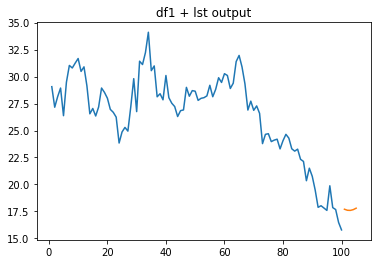

[[17.7031832 ]
 [17.60745317]
 [17.59488843]
 [17.66393778]
 [17.79903362]]


In [226]:
apply_LSTM(df1, split_percentage=0.75)

# AVAX

In [227]:
result1 = pd.read_csv(r'../data/updated_data_ind/avax_ind.csv')

In [228]:
start_date = '2021-07-15'

In [229]:
result1 = result1[result1['Date']> start_date].copy()

In [230]:
df1=result1.reset_index()['close']

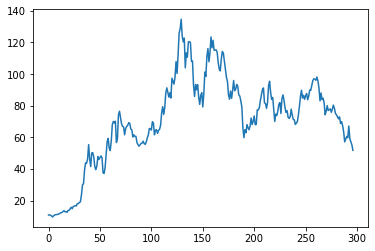

In [231]:
plt.plot(df1)

Sizes train and test:  193 104
Epoch 1/100
2/2 [==============================] - 5s 1s/step - loss: 0.4065 - val_loss: 0.0435
Epoch 2/100
2/2 [==============================] - 0s 202ms/step - loss: 0.2155 - val_loss: 9.3826e-05
Epoch 3/100
2/2 [==============================] - 0s 196ms/step - loss: 0.0570 - val_loss: 0.1117
Epoch 4/100
2/2 [==============================] - 0s 189ms/step - loss: 0.0594 - val_loss: 0.1744
Epoch 5/100
2/2 [==============================] - 0s 191ms/step - loss: 0.0683 - val_loss: 0.0745
Epoch 6/100
2/2 [==============================] - 0s 182ms/step - loss: 0.0242 - val_loss: 0.0208
Epoch 7/100
2/2 [==============================] - 0s 185ms/step - loss: 0.0236 - val_loss: 0.0066
Epoch 8/100
2/2 [==============================] - 0s 220ms/step - loss: 0.0357 - val_loss: 0.0053
Epoch 9/100
2/2 [==============================] - 0s 203ms/step - loss: 0.0368 - val_loss: 0.0102
Epoch 10/100
2/2 [==============================] - 0s 198ms/step - loss: 0.0

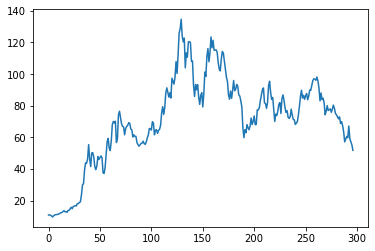

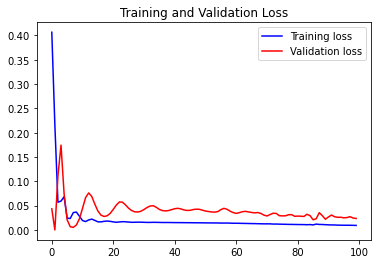

Test RMSE value: 75.90548659795957
Test mae value: 75.90331468898832
Test mse value: 5761.642895673019
Test r2 value: -34159814.13965264
Test rmse2 value: 75.90548659795957


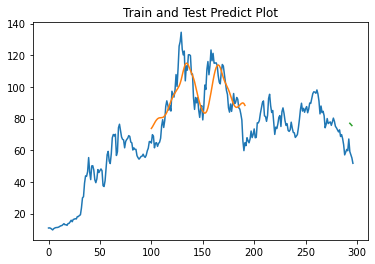

[0.5176528]
101
1 day input [0.46703225 0.48319682 0.51087442 0.46628105 0.46810475 0.54180659
 0.54130892 0.55338266 0.58869433 0.6163784  0.64357775 0.65250915
 0.5772113  0.57330901 0.54926557 0.57950689 0.66481113 0.68622053
 0.62838647 0.59405926 0.60416769 0.54200795 0.48316884 0.51988737
 0.51287487 0.53549917 0.5700014  0.57838613 0.52322522 0.59808118
 0.61727312 0.5896926  0.55178421 0.52853474 0.53712841 0.50350904
 0.4983162  0.5066267  0.54504498 0.51532093 0.49315074 0.49128274
 0.46785073 0.47438371 0.48235569 0.5167595  0.55963865 0.60947727
 0.6409613  0.60116469 0.61498107 0.59521613 0.61339007 0.62383506
 0.59265307 0.61102489 0.64200808 0.64024406 0.66615953 0.6896948
 0.69886097 0.69700739 0.69124254 0.70809478 0.68761468 0.65158724
 0.58700399 0.6267524  0.59351675 0.60012628 0.57787973 0.51667037
 0.53418669 0.5633499  0.53785255 0.54281476 0.54644005 0.52897529
 0.5456666  0.56562362 0.5495155  0.52394234 0.51627277 0.50663996
 0.49609405 0.50621884 0.47262378 0

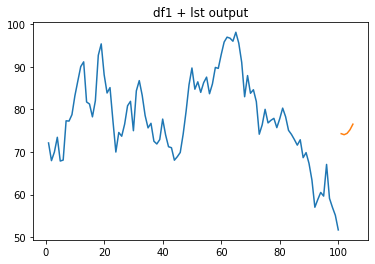

[[74.29530299]
 [74.05584705]
 [74.36384976]
 [75.21334148]
 [76.52428273]]


In [232]:
apply_LSTM(df1, split_percentage=0.65)

# ADX

In [233]:
result1 = pd.read_csv(r'../data/updated_data_ind/axs_ind.csv')

In [234]:
start_date = '2021-03-01'


In [235]:
result1 = result1[result1['Date']> start_date].copy()

In [236]:
df1=result1.reset_index()['close']

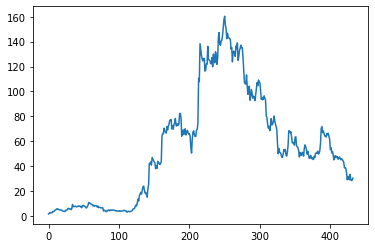

In [237]:
plt.plot(df1)

Sizes train and test:  324 109
Epoch 1/100
4/4 [==============================] - 6s 516ms/step - loss: 0.2534 - val_loss: 2.6205e-04
Epoch 2/100
4/4 [==============================] - 1s 177ms/step - loss: 0.0530 - val_loss: 0.1218
Epoch 3/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0473 - val_loss: 0.0385
Epoch 4/100
4/4 [==============================] - 1s 178ms/step - loss: 0.0186 - val_loss: 0.0097
Epoch 5/100
4/4 [==============================] - 1s 168ms/step - loss: 0.0303 - val_loss: 0.0169
Epoch 6/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0159 - val_loss: 0.0459
Epoch 7/100
4/4 [==============================] - 1s 166ms/step - loss: 0.0160 - val_loss: 0.0531
Epoch 8/100
4/4 [==============================] - 1s 176ms/step - loss: 0.0145 - val_loss: 0.0294
Epoch 9/100
4/4 [==============================] - 1s 174ms/step - loss: 0.0119 - val_loss: 0.0179
Epoch 10/100
4/4 [==============================] - 1s 200ms/step - loss: 

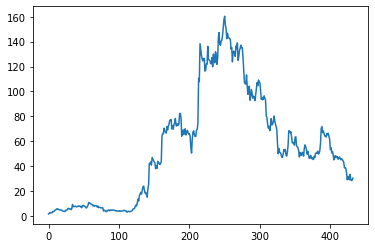

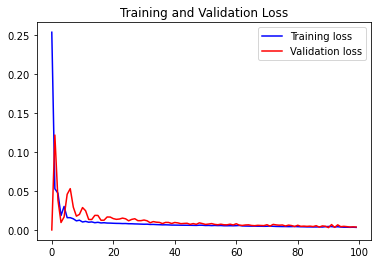

Test RMSE value: 39.30586730396304
Test mae value: 39.14892705352058
Test mse value: 1544.9512045167507
Test r2 value: -14655479.633792393
Test rmse2 value: 39.30586730396304


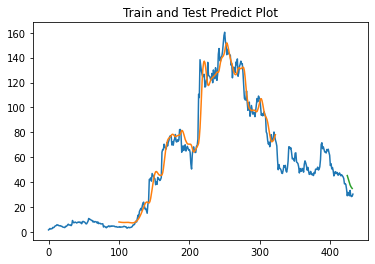

[0.20408605]
101
1 day input [0.32566038 0.31886656 0.32647345 0.2987315  0.29245535 0.3122629
 0.34794729 0.42060138 0.42008869 0.41070856 0.41511406 0.38940231
 0.35903539 0.36199181 0.35777676 0.34782228 0.38826409 0.39008856
 0.34393295 0.3403625  0.33527593 0.31923854 0.28814943 0.31077872
 0.29741202 0.29672355 0.31131877 0.30658153 0.29217557 0.33230865
 0.34934781 0.33939081 0.32517784 0.30252068 0.31652577 0.29732067
 0.2811242  0.28147336 0.2959897  0.28448952 0.27884315 0.28348441
 0.27501092 0.29092263 0.28535374 0.30735121 0.30653639 0.30770198
 0.31758393 0.30291359 0.30641491 0.31955525 0.35565671 0.43249685
 0.44100023 0.41092223 0.41992743 0.4073983  0.3941944  0.39416536
 0.3892514  0.4069735  0.40044807 0.40829346 0.39175579 0.3779868
 0.32561763 0.33494038 0.30867343 0.31563039 0.29935465 0.27329852
 0.28779091 0.29470248 0.28416281 0.29151871 0.2887645  0.27641182
 0.28064428 0.28838658 0.28023538 0.27361441 0.27907172 0.27413996
 0.26902748 0.26022776 0.23322133 0

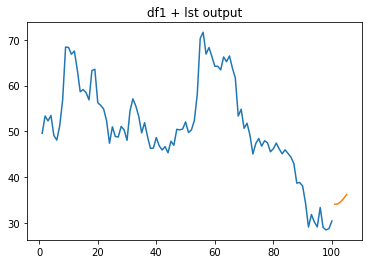

[[34.06472339]
 [34.14753041]
 [34.59761932]
 [35.31253888]
 [36.18940514]]


In [238]:
apply_LSTM(df1, split_percentage=0.75)

# BTC

In [239]:
result1 = pd.read_csv(r'../data/updated_data_ind/btc_ind.csv')

In [240]:
start_date = '2021-01-01'

In [241]:
result1 = result1[result1['Date']> start_date].copy()

In [242]:
df1=result1.reset_index()['close']

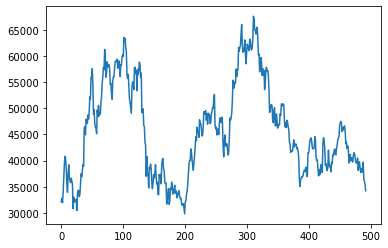

In [243]:
plt.plot(df1)

Sizes train and test:  369 123
Epoch 1/100
5/5 [==============================] - 6s 434ms/step - loss: 0.2494 - val_loss: 0.0024
Epoch 2/100
5/5 [==============================] - 1s 202ms/step - loss: 0.0490 - val_loss: 0.0680
Epoch 3/100
5/5 [==============================] - 1s 172ms/step - loss: 0.0339 - val_loss: 0.0038
Epoch 4/100
5/5 [==============================] - 1s 173ms/step - loss: 0.0387 - val_loss: 0.0036
Epoch 5/100
5/5 [==============================] - 1s 168ms/step - loss: 0.0251 - val_loss: 0.0279
Epoch 6/100
5/5 [==============================] - 1s 188ms/step - loss: 0.0268 - val_loss: 0.0210
Epoch 7/100
5/5 [==============================] - 1s 170ms/step - loss: 0.0200 - val_loss: 0.0051
Epoch 8/100
5/5 [==============================] - 1s 179ms/step - loss: 0.0212 - val_loss: 0.0082
Epoch 9/100
5/5 [==============================] - 1s 174ms/step - loss: 0.0168 - val_loss: 0.0143
Epoch 10/100
5/5 [==============================] - 1s 191ms/step - loss: 0.01

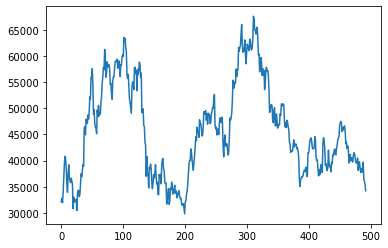

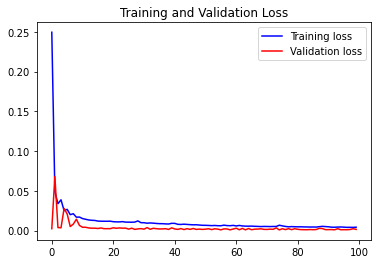

Test RMSE value: 40174.981419348755
Test mae value: 40160.42336127283
Test mse value: 1614029132.0450175
Test r2 value: -907305063560.0253
Test rmse2 value: 40174.981419348755


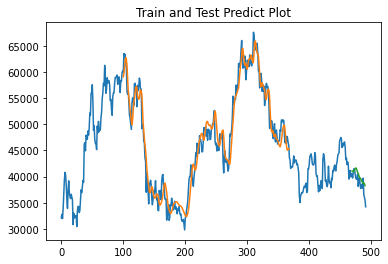

[0.19021165]
101
1 day input [0.21478722 0.22976421 0.23665383 0.18924086 0.19458038 0.30968454
 0.30810319 0.33382572 0.37164011 0.37900674 0.3848424  0.36435262
 0.33370665 0.32937744 0.32813396 0.33844667 0.39110325 0.37485981
 0.28418463 0.27075661 0.27317136 0.2283938  0.1924797  0.22454439
 0.19834019 0.22577805 0.24912607 0.24623752 0.20928353 0.354504
 0.3852619  0.37386027 0.33486799 0.24709709 0.25406171 0.22809203
 0.21861242 0.23649483 0.32245089 0.25503829 0.238023   0.24091073
 0.212988   0.26111075 0.25242502 0.30023141 0.29513201 0.31763701
 0.3279522  0.30298289 0.29848526 0.33240555 0.34655163 0.37483529
 0.38510548 0.38913354 0.45056617 0.45871013 0.46765428 0.45697971
 0.41661929 0.43629564 0.42536606 0.44084872 0.44532732 0.41707789
 0.35486163 0.3627301  0.3305214  0.34361673 0.32840294 0.25727459
 0.2733045  0.30083525 0.26822848 0.28459388 0.28117804 0.2624402
 0.29181724 0.3097342  0.30633449 0.28390263 0.26305904 0.25634311
 0.25588131 0.28207382 0.22008018 0.

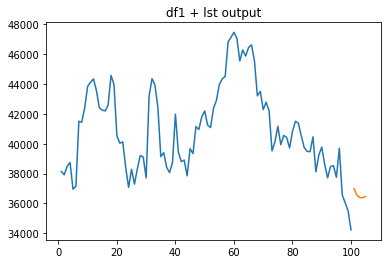

[[36989.64087942]
 [36561.02104055]
 [36388.70863401]
 [36383.54679021]
 [36470.98867182]]


In [244]:
apply_LSTM(df1, split_percentage=0.75)

# Link

In [245]:
result1 = pd.read_csv(r'../data/updated_data_ind/link_ind.csv')

In [246]:
start_date = '2021-01-01'

In [247]:
result1 = result1[result1['Date']> start_date].copy()

In [248]:
df1=result1.reset_index()['close']

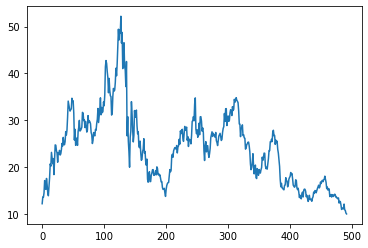

In [249]:
plt.plot(df1)

Sizes train and test:  369 123
Epoch 1/100
5/5 [==============================] - 7s 470ms/step - loss: 0.0982 - val_loss: 0.0396
Epoch 2/100
5/5 [==============================] - 1s 173ms/step - loss: 0.0329 - val_loss: 0.0132
Epoch 3/100
5/5 [==============================] - 1s 175ms/step - loss: 0.0223 - val_loss: 0.0082
Epoch 4/100
5/5 [==============================] - 1s 178ms/step - loss: 0.0197 - val_loss: 0.0186
Epoch 5/100
5/5 [==============================] - 1s 179ms/step - loss: 0.0165 - val_loss: 0.0251
Epoch 6/100
5/5 [==============================] - 1s 179ms/step - loss: 0.0157 - val_loss: 0.0138
Epoch 7/100
5/5 [==============================] - 1s 175ms/step - loss: 0.0151 - val_loss: 0.0112
Epoch 8/100
5/5 [==============================] - 1s 179ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 9/100
5/5 [==============================] - 1s 174ms/step - loss: 0.0132 - val_loss: 0.0144
Epoch 10/100
5/5 [==============================] - 1s 189ms/step - loss: 0.01

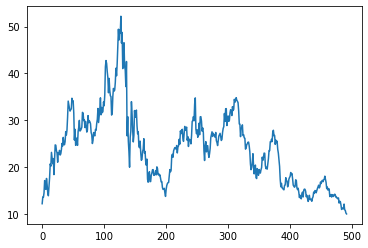

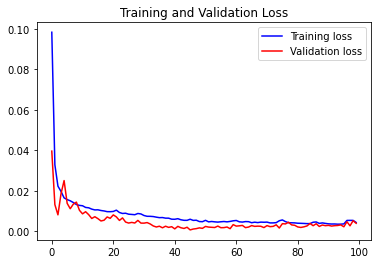

Test RMSE value: 15.102041660646375
Test mae value: 15.080856460512136
Test mse value: 228.0716623198987
Test r2 value: -254336.61547276148
Test rmse2 value: 15.102041660646375


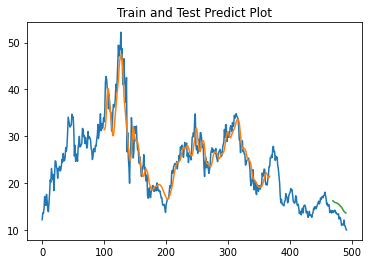

[0.07856429]
101
1 day input [0.18323658 0.17070866 0.16558144 0.13699358 0.14550804 0.17557205
 0.18404695 0.18966343 0.20952711 0.19884164 0.20397465 0.17747418
 0.14565441 0.14012972 0.13501697 0.13985704 0.17259301 0.16913602
 0.1311355  0.12307314 0.12993321 0.10923644 0.08288121 0.09447777
 0.07977541 0.07645516 0.10186978 0.1102142  0.0856366  0.12032348
 0.12550059 0.1245574  0.11511965 0.08707441 0.09436689 0.07813723
 0.06330096 0.07195462 0.09421525 0.07475895 0.07197096 0.07453201
 0.06395894 0.07963971 0.08706022 0.11035843 0.10384217 0.11823853
 0.11697124 0.10693635 0.11774564 0.128256   0.13654462 0.14535411
 0.13143605 0.13705823 0.16143562 0.15354807 0.16436774 0.16998082
 0.16289374 0.17241528 0.17456925 0.19096255 0.17626474 0.15963765
 0.12770872 0.13595245 0.1207638  0.12783765 0.12583412 0.08797335
 0.09321172 0.0982007  0.085441   0.09669742 0.09740915 0.08826318
 0.09473258 0.09996668 0.09440848 0.08408231 0.08457118 0.07826987
 0.07693423 0.08099714 0.05480495

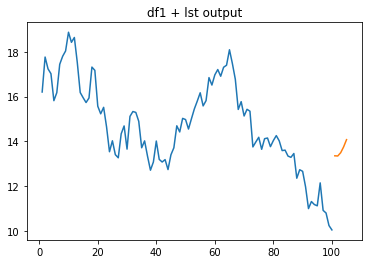

[[13.35613715]
 [13.34723941]
 [13.49421568]
 [13.75330655]
 [14.07758551]]


In [250]:
apply_LSTM(df1, split_percentage=0.75)

# Luna1

In [251]:
result1 = pd.read_csv(r'../data/updated_data_ind/luna1_ind.csv')

In [252]:
start_date = '2021-01-01'

In [253]:
result1 = result1[result1['Date']> start_date].copy()

In [254]:
df1=result1.reset_index()['close']

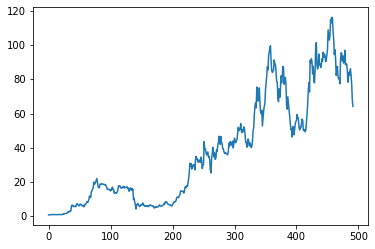

In [255]:
plt.plot(df1)

Sizes train and test:  369 123
Epoch 1/100
5/5 [==============================] - 8s 510ms/step - loss: 0.0703 - val_loss: 0.0075
Epoch 2/100
5/5 [==============================] - 1s 184ms/step - loss: 0.0207 - val_loss: 0.0032
Epoch 3/100
5/5 [==============================] - 1s 186ms/step - loss: 0.0097 - val_loss: 0.0358
Epoch 4/100
5/5 [==============================] - 1s 183ms/step - loss: 0.0112 - val_loss: 0.0066
Epoch 5/100
5/5 [==============================] - 1s 191ms/step - loss: 0.0053 - val_loss: 0.0694
Epoch 6/100
5/5 [==============================] - 1s 187ms/step - loss: 0.0040 - val_loss: 0.0162
Epoch 7/100
5/5 [==============================] - 1s 187ms/step - loss: 0.0042 - val_loss: 0.0443
Epoch 8/100
5/5 [==============================] - 1s 179ms/step - loss: 0.0037 - val_loss: 0.0647
Epoch 9/100
5/5 [==============================] - 1s 196ms/step - loss: 0.0033 - val_loss: 0.0133
Epoch 10/100
5/5 [==============================] - 1s 199ms/step - loss: 0.00

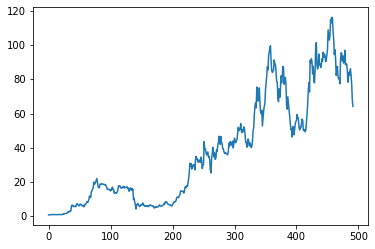

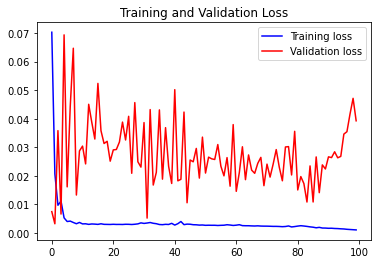

Test RMSE value: 107.96765077236462
Test mae value: 107.79178471232264
Test mse value: 11657.013613303287
Test r2 value: -3286892.309050202
Test rmse2 value: 107.96765077236462


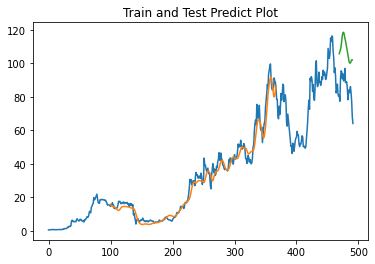

[0.8367411]
101
1 day input [0.39422163 0.44664434 0.44388599 0.40540291 0.43531483 0.46001778
 0.47283265 0.47911603 0.50820071 0.48941119 0.48937192 0.44518874
 0.42976439 0.44370688 0.44191284 0.45966003 0.48518897 0.47871225
 0.42860526 0.43268366 0.43014438 0.42092061 0.42793522 0.46773449
 0.50976946 0.55933652 0.62655816 0.66893879 0.62197482 0.78173364
 0.76788959 0.79012892 0.77461195 0.71379682 0.74952079 0.67788945
 0.66775778 0.73302057 0.85350573 0.87198794 0.75651504 0.73855776
 0.7513238  0.81381529 0.76010768 0.76566366 0.74521422 0.75988416
 0.79006296 0.7764968  0.82328021 0.79783295 0.81443716 0.80525658
 0.77551751 0.78388715 0.8077573  0.83519723 0.93590728 0.91023188
 0.88428202 0.90815527 0.98947545 0.97115963 1.         0.99744675
 0.9262566  0.88899524 0.81138019 0.83595959 0.79417085 0.7061956
 0.72438516 0.75155055 0.69976042 0.68856537 0.6942878  0.66330433
 0.78117885 0.82040196 0.81470285 0.77880188 0.80370424 0.76788089
 0.77673825 0.83266876 0.75937939 0

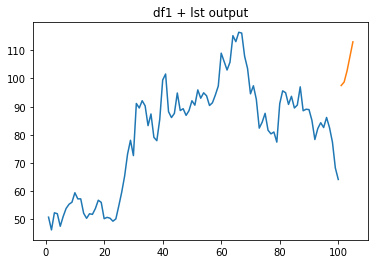

[[ 97.50721274]
 [ 98.73320175]
 [102.70177846]
 [107.86155686]
 [113.00702284]]


In [256]:
apply_LSTM(df1, split_percentage=0.75)

# Matic 

In [257]:
result1 = pd.read_csv(r'../data/updated_data_ind/matic_ind.csv')

In [258]:
start_date = '2021-01-01'

In [259]:
result1 = result1[result1['Date']> start_date].copy()

In [260]:
df1=result1.reset_index()['close']

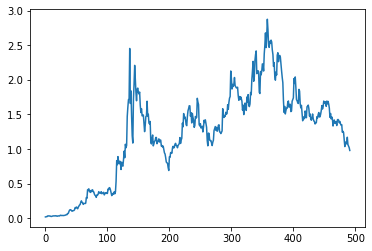

In [261]:
plt.plot(df1)

Sizes train and test:  369 123
Epoch 1/100
5/5 [==============================] - 6s 455ms/step - loss: 0.1687 - val_loss: 0.0368
Epoch 2/100
5/5 [==============================] - 1s 161ms/step - loss: 0.0373 - val_loss: 0.0093
Epoch 3/100
5/5 [==============================] - 1s 157ms/step - loss: 0.0196 - val_loss: 0.0016
Epoch 4/100
5/5 [==============================] - 1s 159ms/step - loss: 0.0174 - val_loss: 0.0165
Epoch 5/100
5/5 [==============================] - 1s 159ms/step - loss: 0.0154 - val_loss: 0.0261
Epoch 6/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0126 - val_loss: 0.0048
Epoch 7/100
5/5 [==============================] - 1s 158ms/step - loss: 0.0124 - val_loss: 0.0061
Epoch 8/100
5/5 [==============================] - 1s 158ms/step - loss: 0.0112 - val_loss: 0.0150
Epoch 9/100
5/5 [==============================] - 1s 160ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 10/100
5/5 [==============================] - 1s 161ms/step - loss: 0.01

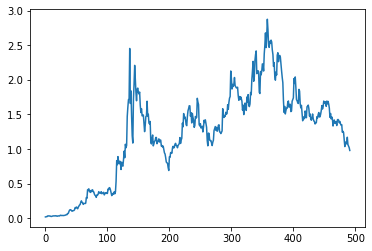

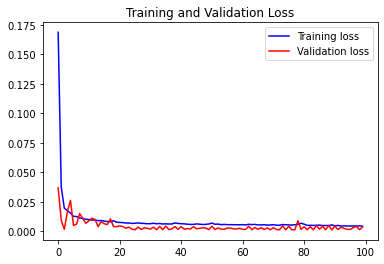

Test RMSE value: 0.9660364426616264
Test mae value: 0.9639909504271581
Test mse value: 0.9332264085503297
Test r2 value: -361.05476247592685
Test rmse2 value: 0.9660364426616264


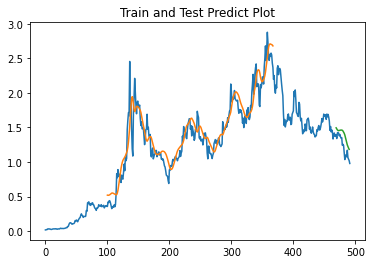

[0.39388233]
101
1 day input [0.5550895  0.56859366 0.56987861 0.5328882  0.53581396 0.58500852
 0.59324238 0.60219745 0.69989473 0.6752149  0.70816221 0.65676272
 0.59333369 0.58804629 0.57772685 0.57382755 0.64520523 0.6366918
 0.5731249  0.55165461 0.5643644  0.52377741 0.48631321 0.50580045
 0.4980663  0.49709313 0.53595533 0.52358319 0.50178535 0.55714046
 0.56069607 0.56555765 0.54777004 0.50946423 0.52112388 0.49608009
 0.48896427 0.4990846  0.52061684 0.49695456 0.48551432 0.48305815
 0.47024758 0.47550458 0.47630834 0.50715923 0.50042378 0.51807565
 0.52805428 0.50560556 0.50650627 0.52013779 0.53793349 0.56329011
 0.54607637 0.55700468 0.58593618 0.57435562 0.57939461 0.58283509
 0.55927326 0.58608773 0.57212934 0.58430166 0.57069217 0.55074723
 0.50379572 0.52314927 0.49573156 0.50574656 0.49494878 0.45985394
 0.48074268 0.49027408 0.47366462 0.48198595 0.48006519 0.46226844
 0.49064113 0.49309801 0.48944754 0.47619146 0.48293709 0.47133059
 0.463728   0.46667478 0.42824091 

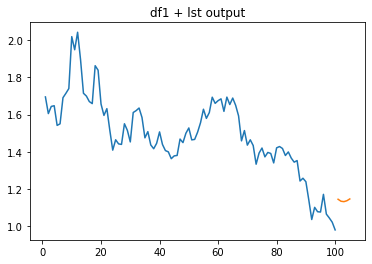

[[1.14464602]
 [1.13396478]
 [1.13188127]
 [1.13660179]
 [1.1463571 ]]


In [262]:
apply_LSTM(df1, split_percentage=0.75)

# Solana

In [263]:
result1 = pd.read_csv(r'../data/updated_data_ind/sol_ind.csv')

In [264]:
start_date = '2021-01-01'

In [265]:
result1 = result1[result1['Date']> start_date].copy()

In [266]:
df1=result1.reset_index()['close']

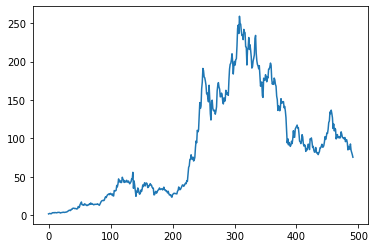

In [267]:
plt.plot(df1)

Sizes train and test:  369 123
Epoch 1/100
5/5 [==============================] - 6s 428ms/step - loss: 0.1752 - val_loss: 0.0020
Epoch 2/100
5/5 [==============================] - 1s 162ms/step - loss: 0.0386 - val_loss: 0.0547
Epoch 3/100
5/5 [==============================] - 1s 171ms/step - loss: 0.0168 - val_loss: 4.3056e-04
Epoch 4/100
5/5 [==============================] - 1s 157ms/step - loss: 0.0204 - val_loss: 8.3862e-04
Epoch 5/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0114 - val_loss: 0.0175
Epoch 6/100
5/5 [==============================] - 1s 159ms/step - loss: 0.0109 - val_loss: 0.0099
Epoch 7/100
5/5 [==============================] - 1s 157ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 8/100
5/5 [==============================] - 1s 158ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 9/100
5/5 [==============================] - 1s 158ms/step - loss: 0.0074 - val_loss: 0.0086
Epoch 10/100
5/5 [==============================] - 1s 157ms/step - lo

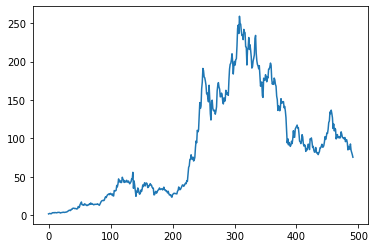

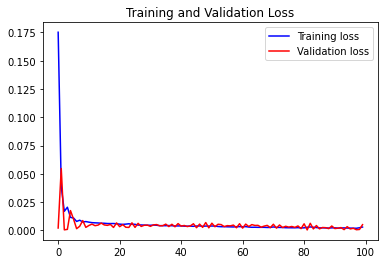

Test RMSE value: 112.84660623957338
Test mae value: 112.65362918716832
Test mse value: 12734.35653978932
Test r2 value: -12976403.79292243
Test rmse2 value: 112.84660623957338


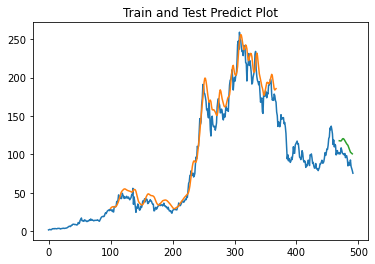

[0.36960566]
101
1 day input [0.35583792 0.38088764 0.42071163 0.38904974 0.38757751 0.42924904
 0.43593834 0.44140417 0.44939759 0.43477622 0.43642476 0.40602605
 0.36783241 0.36602917 0.35562957 0.36803228 0.40085562 0.38942036
 0.35627639 0.34326781 0.34883372 0.34651883 0.31626916 0.32926709
 0.32319013 0.3398816  0.35312007 0.34356377 0.32558679 0.38003793
 0.37666697 0.38442974 0.36455522 0.33619183 0.34164369 0.32178774
 0.312407   0.31289194 0.33602105 0.31555329 0.30702045 0.31016597
 0.29998554 0.30868629 0.31561551 0.33486042 0.33475627 0.34232113
 0.35241744 0.33762642 0.33817998 0.34500818 0.36285761 0.39055126
 0.37668466 0.38876422 0.40945389 0.40704673 0.42744479 0.46240375
 0.47003388 0.51580546 0.50712492 0.52492281 0.50795624 0.48637072
 0.43200687 0.45500308 0.42001899 0.43235459 0.42756973 0.37933307
 0.39476187 0.4013559  0.38465595 0.38699703 0.39068202 0.38349662
 0.39029784 0.41527888 0.40328118 0.38881072 0.38428358 0.38479843
 0.3789313  0.38675536 0.36550005

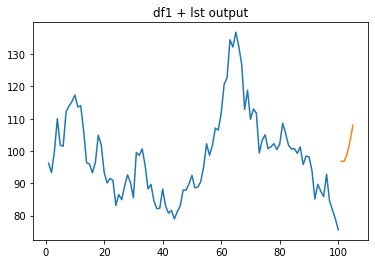

[[ 96.83784544]
 [ 96.7827622 ]
 [ 99.03100584]
 [102.96731162]
 [107.97923486]]


In [268]:
apply_LSTM(df1, split_percentage=0.75)